# RFM ANALYSIS on Ecommerce Data 

Author: Shreejit Pillai

Data: 2020-06-27

References- Book - Learning Apache Spark With Python //Chapter 13  
            https://runawayhorse001.github.io/LearningApacheSpark/rfm.html

Dataset   - https://www.kaggle.com/carrie1/ecommerce-data

Notes     -      

In [ ]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Python Spark RFM example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
df_raw = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load("/Users/spillai/Downloads/rfm_data2.csv",header=True);


Check the dataset

In [4]:
df_raw.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df_raw.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 00:00:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 00:00:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 00:00:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 00:00:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 00:00:00|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



Data Cleaning

In [6]:
from pyspark.sql.functions import count

def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

In [7]:
my_count(df_raw)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   541909|   541909|     540455|  541909|     541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Dropping NULL from the dataset

In [37]:
df = df_raw.dropna(how='any')
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|   406829|   406829|     406829|  406829|     406829|   406829|    406829| 406829|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Using a subset of the data for Analysis

In [39]:
#import org.apache.spark.sql.functions.rand
df=df.orderBy(rand()).limit(20000)

In [40]:
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|    20000|    20000|      20000|   20000|      20000|    20000|     20000|  20000|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Dealwith the InvoiceDate

In [41]:
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

timeFmt = "yyyy-MM-dd"

df = df.withColumn('NewInvoiceDate'
                 , to_utc_timestamp(unix_timestamp(col('InvoiceDate'),timeFmt).cast('timestamp')
                 , 'UTC'))  

Calculate Total Price

In [42]:
from pyspark.sql.functions import round

df = df.withColumn('TotalPrice', round( df.Quantity * df.UnitPrice, 2 ) )

In [43]:
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date
date_max = df.select(max('NewInvoiceDate')).toPandas()

In [44]:
date_max.iloc[0][0]

Timestamp('2011-12-09 00:00:00')

In [45]:
# Calculatre Duration
df = df.withColumn('Duration', datediff(lit(date_max.iloc[0][0]), 'NewInvoiceDate'))

In [46]:
df.show(3)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+----------+--------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|TotalPrice|Duration|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-------------------+----------+--------+
|   539075|    22970|LONDON BUS COFFEE...|       3|2010-12-15 00:00:00|     2.55|     17189|United Kingdom|2010-12-15 00:00:00|      7.65|     359|
|   552816|    22456|NATURAL SLATE CHA...|       1|2011-05-11 00:00:00|     4.95|     15521|United Kingdom|2011-05-11 00:00:00|      4.95|     212|
|   575637|    23147|SINGLE ANTIQUE RO...|       2|2011-11-10 00:00:00|     1.45|     16904|United Kingdom|2011-11-10 00:00:00|       2.9|      29|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----

Building the Recency, Frequency and Monetary

In [47]:
recency = df.groupBy('CustomerID').agg(min('Duration').alias('Recency'))
frequency = df.groupBy('CustomerID', 'InvoiceNo').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))
monetary = df.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))
rfm = recency.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')

In [48]:
rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     17189|    106|        2|    32.3|
|     15521|     40|        4|   43.55|
|     16904|      4|       13|  171.35|
|     12528|      9|        3|  120.66|
|     12766|      3|        4|  174.87|
+----------+-------+---------+--------+
only showing top 5 rows



Determining Cut points

In this section, you can use the techniques (statistical results and visualizations) in Data Exploration section to help you determine the cutting points for each attribute. In my opinion, the cutting points are mainly depend on the business sense. You’s better talk to your marketing people and get feedback and suggestion from them. 

You may find out that the default function in PySpark does not include the quartiles. The following function will help you to get the same results in Pandas

In [49]:
def describe_pd(df_in, columns, deciles=False):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    :author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [51]:
import numpy as np
import pandas as pd
cols = ['Recency','Frequency','Monetary']
describe_pd(rfm,cols,0) # If you are looking for Deciles then pass 1 in the function 

/Users/spillai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,summary,Recency,Frequency,Monetary
0,count,3288,3288,3288
1,mean,102.10492700729927,3.0173357664233578,96.67289537712955
2,stddev,102.36759878724881,4.972636161318731,1428.640749161816
3,min,0,1,-77183.6
4,max,373,130,15046.01
5,25%,22,1,18.545
6,50%,61,2,45
7,75%,163,3,105.01


The user defined function by using the cutting points.

I will use the quantile as the cutting points in this case

In [52]:
def RScore(x):
    if  x <= 22:
        return 1
    elif x<= 61:
        return 2
    elif x<= 163:
        return 3
    else:
        return 4

def FScore(x):
    if  x <= 1:
        return 4
    elif x <= 2:
        return 3
    elif x <= 3:
        return 2
    else:
        return 1

def MScore(x):
    if  x <= 18.545:
        return 4
    elif x <= 45:
        return 3
    elif x <= 105.01:
        return 2
    else:
        return 1

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())


In [53]:
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     17189|    106|        2|    32.3|    3|    3|    3|
|     15521|     40|        4|   43.55|    2|    1|    3|
|     16904|      4|       13|  171.35|    1|    1|    1|
|     12528|      9|        3|  120.66|    1|    2|    1|
|     12766|      3|        4|  174.87|    1|    1|    1|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



In [54]:
from pyspark.sql import functions as F

In [55]:
rfm_seg = rfm_seg.withColumn('RFMScore',
                             F.concat(F.col('r_seg'),F.col('f_seg'), F.col('m_seg')))
rfm_seg.sort(F.col('RFMScore')).show(5)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     14546|      5|        6|  111.41|    1|    1|    1|     111|
|     13709|      3|        9|  335.14|    1|    1|    1|     111|
|     14911|      1|      130| 6810.03|    1|    1|    1|     111|
|     16904|      4|       13|  171.35|    1|    1|    1|     111|
|     14796|      1|       15|  319.41|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



Statistical Summary

In [56]:
rfm_seg.groupBy('RFMScore')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} )\
        .sort(F.col('RFMScore')).show(5)

+--------+-----------------+-----------------+-----------------+
|RFMScore|     avg(Recency)|    avg(Monetary)|   avg(Frequency)|
+--------+-----------------+-----------------+-----------------+
|     111|9.148148148148149|572.4890909090913| 10.8989898989899|
|     112|           9.5375|77.78200000000001|           5.4125|
|     113|7.933333333333334|            33.38|4.866666666666666|
|     114|              7.8|           -49.64|              4.8|
|     121|9.483870967741936|272.7345161290323|              3.0|
+--------+-----------------+-----------------+-----------------+
only showing top 5 rows



Complex Summary

In [58]:

#grp = 'RFMScore'
#num_cols = ['Recency','Frequency','Monetary']
#df_input = rfm_seg

#quantile_grouped = quantile_agg(df_input,grp,num_cols)
#quantile_grouped.toPandas().to_csv(output_dir+'quantile_grouped.csv')

#deciles_grouped = deciles_agg(df_input,grp,num_cols)
#deciles_grouped.toPandas().to_csv(output_dir+'deciles_grouped.csv')


Extension

**K-means Clustering**

Building a dense Feature Matrix 

In [59]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

# method 1 (good for small feature):
#def transData(row):
#    return Row(label=row["Sales"],
#               features=Vectors.dense([row["TV"],
#                                       row["Radio"],
#                                       row["Newspaper"]]))

# Method 2 (good for large features):
def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm'])

In [60]:
transformed= transData(rfm)
transformed.show(5)

+----------+-----------------+
|CustomerID|              rfm|
+----------+-----------------+
|     17189| [106.0,2.0,32.3]|
|     15521| [40.0,4.0,43.55]|
|     16904|[4.0,13.0,171.35]|
|     12528| [9.0,3.0,120.66]|
|     12766| [3.0,4.0,174.87]|
+----------+-----------------+
only showing top 5 rows



Scaling the Feature Matrix

In [61]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="rfm",\
         outputCol="features")
scalerModel =  scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)
scaledData.show(5,False)

+----------+-----------------+-------------------------------------------------------------+
|CustomerID|rfm              |features                                                     |
+----------+-----------------+-------------------------------------------------------------+
|17189     |[106.0,2.0,32.3] |[0.28418230563002683,0.007751937984496124,0.8372137754892383]|
|15521     |[40.0,4.0,43.55] |[0.10723860589812333,0.023255813953488372,0.8373357536695646]|
|16904     |[4.0,13.0,171.35]|[0.010723860589812333,0.09302325581395349,0.8387214257980709]|
|12528     |[9.0,3.0,120.66] |[0.024128686327077747,0.015503875968992248,0.838171819223783]|
|12766     |[3.0,4.0,174.87] |[0.00804289544235925,0.023255813953488372,0.8387595914153817]|
+----------+-----------------+-------------------------------------------------------------+
only showing top 5 rows



In [62]:
#scaledData

Finding the optimal Number of Clusters 

In [63]:
#Elbow Analysis
#PySpark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator  # requires Spark 2.4 or later

import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(scaledData)
    cost[k] = model.computeCost(scaledData) # requires Spark 2.0 or later


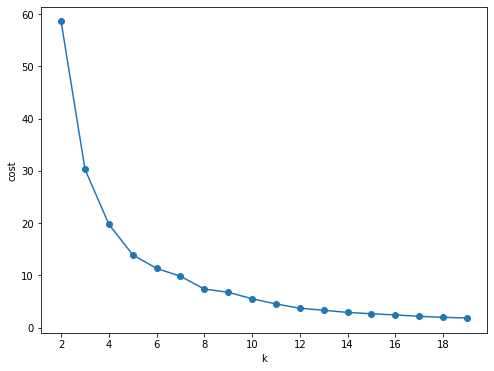

In [68]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20], marker = "o")
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In my opinion, sometimes it’s hard to choose the number of the clusters. As shown in Figure Cost v.s. the number of the clusters, you can choose 3, 5 or even 8. I will choose 3 in this demo.

In [85]:
#Silhouette analysis

#PySpark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import time # Added by SHREEJIT 

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    '''
    Determine optimal number of clusters by using Silhoutte Score Analysis.
    :param df_in: the input dataframe
    :param index_col: the name of the index column
    :param k_min: the train dataset
    :param k_min: the minmum number of the clusters
    :param k_max: the maxmum number of the clusters
    :param num_runs: the number of runs for each fixed clusters

    :return k: optimal number of the clusters
    :return silh_lst: Silhouette score
    :return r_table: the running results table

    :author: Wenqiang Feng
    :email:  von198@gmail.com.com
    '''

    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    elapsed =  time.time() - start

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')


    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table

In [90]:
# num_runs is the last parameter to optimal_k. Kept it as 1 for now 
k, silh_lst, r_table = optimal_k(scaledData,'CustomerID',3,10,1)

+------------------------------------------------------------+
|         The finding optimal k phase took       14 s.       |
+------------------------------------------------------------+


In [91]:
k

3

In [92]:
silh_lst

,k,silhouette
0,3,0.799660
1,4,0.706428
2,5,0.692059
3,6,0.732205
4,7,0.622674
5,8,0.661743
6,9,0.679322
7,10,0.571296


Using K means (k=3) to cluster the customers 

In [89]:
k = 3
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(scaledData)
# Make predictions
predictions = model.transform(scaledData)
predictions.show(5,False)

+----------+-----------------+-------------------------------------------------------------+----------+
|CustomerID|rfm              |features                                                     |prediction|
+----------+-----------------+-------------------------------------------------------------+----------+
|17189     |[106.0,2.0,32.3] |[0.28418230563002683,0.007751937984496124,0.8372137754892383]|0         |
|15521     |[40.0,4.0,43.55] |[0.10723860589812333,0.023255813953488372,0.8373357536695646]|2         |
|16904     |[4.0,13.0,171.35]|[0.010723860589812333,0.09302325581395349,0.8387214257980709]|2         |
|12528     |[9.0,3.0,120.66] |[0.024128686327077747,0.015503875968992248,0.838171819223783]|2         |
|12766     |[3.0,4.0,174.87] |[0.00804289544235925,0.023255813953488372,0.8387595914153817]|2         |
+----------+-----------------+-------------------------------------------------------------+----------+
only showing top 5 rows



Statistical Summary

In [94]:
results = rfm.join(predictions.select('CustomerID','prediction'),'CustomerID',how='left')
results.show(5)

+----------+-------+---------+--------+----------+
|CustomerID|Recency|Frequency|Monetary|prediction|
+----------+-------+---------+--------+----------+
|     13098|     21|       21| 1525.75|         2|
|     13248|    189|        1|   33.48|         0|
|     13460|     29|        1|    17.0|         2|
|     13518|     85|        1|    19.8|         2|
|     14719|      1|        5|  102.94|         2|
+----------+-------+---------+--------+----------+
only showing top 5 rows



In [95]:
#Simple Summary 
results.groupBy('prediction')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} )\
        .sort(F.col('prediction')).show(5)

+----------+------------------+------------------+------------------+
|prediction|      avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+----------+------------------+------------------+------------------+
|         0|158.72837632776935| 61.96878603945374|1.9013657056145676|
|         1|296.52107279693485|-115.4552490421456|1.2452107279693487|
|         2| 36.22923588039867|160.08101091599437| 3.805410536307546|
+----------+------------------+------------------+------------------+



In [ ]:
#Complex Summary 
grp = 'RFMScore'
num_cols = ['Recency','Frequency','Monetary']
df_input = results

quantile_grouped = quantile_agg(df_input,grp,num_cols)
quantile_grouped.toPandas().to_csv(output_dir+'quantile_grouped.csv')

deciles_grouped = deciles_agg(df_input,grp,num_cols)
deciles_grouped.toPandas().to_csv(output_dir+'deciles_grouped.csv')

In [96]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import gridspec 
from sklearn.cluster import OPTICS, cluster_optics_dbscan 
from sklearn.preprocessing import normalize, StandardScaler

In [98]:
rfm_seg.show(3)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     17189|    106|        2|    32.3|    3|    3|    3|     333|
|     15521|     40|        4|   43.55|    2|    1|    3|     213|
|     16904|      4|       13|  171.35|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 3 rows



# Optics- Density Based Clustering Approach

In [99]:
df=rfm_seg.toPandas()

In [100]:
df.head(3)

,CustomerID,Recency,Frequency,Monetary,r_seg,f_seg,m_seg,RFMScore
0,17189,106,2,32.30,3,3,3,333
1,15521,40,4,43.55,2,1,3,213
2,16904,4,13,171.35,1,1,1,111


In [101]:
#Dropping irrelevant columns 
drop_features = ['CustomerID', 'r_seg','f_seg','m_seg'] 
X = df.drop(drop_features, axis = 1) 

In [102]:
X.head(1)

,Recency,Frequency,Monetary,RFMScore
0,106,2,32.3,333


In [103]:
#Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 

In [104]:
# Normalizing the data so that the data 
# approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 

In [105]:
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

In [106]:
X_normalized.head(5)

,0,1,2,3
0,0.077470,-0.416540,-0.091740,0.901153
1,-0.707004,0.230291,-0.043333,-0.667258
2,-0.361917,0.758125,0.019740,-0.542101
3,-0.558457,-0.002141,0.010309,-0.829467
4,-0.555265,0.113341,0.031393,-0.823316


In [107]:
# Renaming the columns 
X_normalized.columns = X.columns 

In [108]:
X_normalized.head(5)

,Recency,Frequency,Monetary,RFMScore
0,0.077470,-0.416540,-0.091740,0.901153
1,-0.707004,0.230291,-0.043333,-0.667258
2,-0.361917,0.758125,0.019740,-0.542101
3,-0.558457,-0.002141,0.010309,-0.829467
4,-0.555265,0.113341,0.031393,-0.823316


In [109]:
# Building the OPTICS Clustering model 
optics_model = OPTICS(min_samples = 10, xi = 0.05, min_cluster_size = 0.05) 

In [110]:
# Training the model 
optics_model.fit(X_normalized) 

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=10, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [111]:
# Producing the labels according to the DBSCAN technique with eps = 0.5 
labels1 = cluster_optics_dbscan(reachability = optics_model.reachability_, 
                                   core_distances = optics_model.core_distances_, 
                                   ordering = optics_model.ordering_, eps = 0.5) 

In [112]:
# Producing the labels according to the DBSCAN technique with eps = 2.0 
labels2 = cluster_optics_dbscan(reachability = optics_model.reachability_, 
                                   core_distances = optics_model.core_distances_, 
                                   ordering = optics_model.ordering_, eps = 2) 

In [113]:
# Creating a numpy array with numbers at equal spaces till 
# the specified range 
space = np.arange(len(X_normalized))

In [114]:
# Storing the reachability distance of each point 
reachability = optics_model.reachability_[optics_model.ordering_] 

In [115]:
# Storing the cluster labels of each point 
# Question is whether these labels are in the right order of the data 
labels = optics_model.labels_[optics_model.ordering_] 

In [116]:
print(labels) 

[-1 -1 -1 ... -1 -1 -1]


In [117]:
lb=pd.DataFrame(labels)

In [124]:
#Renaming the column
lb.columns=['labels_optics']

In [127]:
# Rename the Label to Cluster Label
lb.head(2)

,labels_optics
0,-1
1,-1


In [120]:
#Lets try to append the Labels to the Original Dataset (X in this case)
# 
#mergedDf = X.merge(lb, left_index=True, right_index=True)

In [121]:
#mergedDf.to_csv('/Users/spillai/Downloads/opt_out.csv')

In [126]:
# OR merging in a way that we have the customer ID's and everything else we started with
mergedDf2 = df.merge(lb, left_index=True, right_index=True)
mergedDf2.to_csv('/Users/spillai/Downloads/opt_out2.csv')

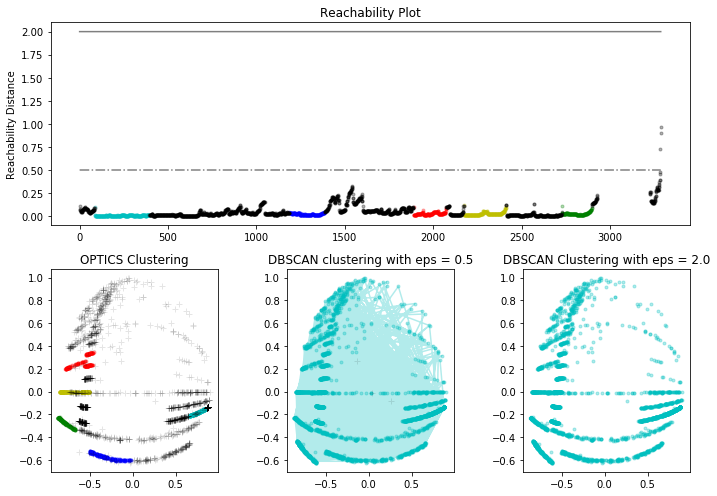

In [119]:

# Defining the framework of the visualization 
plt.figure(figsize =(10, 7)) 
G = gridspec.GridSpec(2, 3) 
ax1 = plt.subplot(G[0, :]) 
ax2 = plt.subplot(G[1, 0]) 
ax3 = plt.subplot(G[1, 1]) 
ax4 = plt.subplot(G[1, 2]) 
  
# Plotting the Reachability-Distance Plot 
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = space[labels == Class] 
    Rk = reachability[labels == Class] 
    ax1.plot(Xk, Rk, colour, alpha = 0.3) 
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.3) 
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5) 
ax1.set_ylabel('Reachability Distance') 
ax1.set_title('Reachability Plot') 
  
# Plotting the OPTICS Clustering 
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = X_normalized[optics_model.labels_ == Class] 
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
      
ax2.plot(X_normalized.iloc[optics_model.labels_ == -1, 0], 
        X_normalized.iloc[optics_model.labels_ == -1, 1], 
       'k+', alpha = 0.1) 
ax2.set_title('OPTICS Clustering') 
  
# Plotting the DBSCAN Clustering with eps = 0.5 
colors = ['c', 'b', 'r', 'y', 'g', 'greenyellow'] 
for Class, colour in zip(range(0, 6), colors): 
    Xk = X_normalized[labels1 == Class] 
    ax3.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3, marker ='.') 
        
ax3.plot(X_normalized.iloc[labels1 == -1, 0], 
        X_normalized.iloc[labels1 == -1, 1], 
       'k+', alpha = 0.1) 
ax3.set_title('DBSCAN clustering with eps = 0.5') 
  
# Plotting the DBSCAN Clustering with eps = 2.0 
colors = ['c.', 'y.', 'm.', 'g.'] 
for Class, colour in zip(range(0, 4), colors): 
    Xk = X_normalized.iloc[labels2 == Class] 
    ax4.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
          
ax4.plot(X_normalized.iloc[labels2 == -1, 0], 
        X_normalized.iloc[labels2 == -1, 1], 
       'k+', alpha = 0.1) 
ax4.set_title('DBSCAN Clustering with eps = 2.0') 
  
  
plt.tight_layout() 
plt.show() 

In [128]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import Birch

In [228]:
##########################################################################################
# Need to look at these 3 parameters very closely to get a meaningful cluster allocation #  
##########################################################################################
brc = Birch(branching_factor=50, n_clusters=4, threshold=0.3)
brc.fit(X_normalized)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=4,
      threshold=0.3)

In [229]:
labels_birch = brc.predict(X)

In [230]:
labels_birch=pd.DataFrame(labels_birch)

In [231]:
labels_birch.columns=['Birch_Label']

In [232]:
#labels_birch.groupby('Birch_Label').count()
labels_birch.Birch_Label.value_counts()

0    2618
1     424
2     246
Name: Birch_Label, dtype: int64

In [134]:
mergedDfbirch = df.merge(labels_birch, left_index=True, right_index=True)
mergedDfbirch.to_csv('/Users/spillai/Downloads/birch_out.csv')